# ESO 137-002 Sky Area

A notebook to determine the area of each area less the foreground masks.

In [1]:
# Python Imports
from IPython.display import display
from os import path
import pickle as p
from warnings import catch_warnings, simplefilter

# 3rd Party Imports
import numpy as np
from scipy import ndimage as ndi
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
import pyregion as pyreg


## Notebook Setup

In [33]:
# Directories
REG_DIR = path.join('../../../../09_color_mag_regions/')

# Included Region Files
INC_REG_FNS = {  # Short Names
    'tail': 'tail.reg',
    'control': 'control.reg'
    
}
INC_REG_FNS = {key: path.join(REG_DIR, val) for key, val in INC_REG_FNS.items()}  # Full Names

# Exclude Region Files
EXC_REG_FNS = {  # Short Names
#     'gsc2':     'ESO_Guide_Star_Coords-img.reg',
    'tail-exc': 'tail_remove_srcs.reg', 
    'control-exc': 'control_remove_srcs.reg'
}
EXC_REG_FNS = {key: path.join(REG_DIR, val) for key, val in EXC_REG_FNS.items()}  # Full Names

# Image Information
IMG_FNS = {
    475: 'F475W_drc_chip_cleaned.fits',
    814: 'F814W_drc_chip_cleaned.fits'
}
IMG_FNS = {key: path.join('../../../../08_drc_cosmicray/', val) for key, val in IMG_FNS.items()}

In [35]:
# Astropy Setup 
# I simply copied 0.03, 101.93 from Wills eso -001 notebook since they lie at same distance
# i.e., they will be different for IC 3418 
ASPP  = 0.03 * u.arcsec / u.pixel
PPKPC = 101.93679918450562 * u.pixel / u.kpc
_ = u.set_enabled_equivalencies([
    (u.pix, u.arcsec, lambda x: x*ASPP, lambda x: x/ASPP),
    (u.pix**2, u.arcsec**2, lambda x: x*ASPP**2, lambda x: x/ASPP**2),
    (u.kpc, u.pix, lambda x: x*PPKPC, lambda x: x/PPKPC),
    (u.kpc**2, u.pix**2, lambda x: x*PPKPC**2, lambda x: x/PPKPC**2),
    (u.kpc, u.arcsec, lambda x: x*PPKPC*ASPP, lambda x: x/ASPP/PPKPC),
    (u.kpc**2, u.arcsec**2, lambda x: x*PPKPC**2*ASPP**2, lambda x: x/ASPP**2/PPKPC**2)
])

## Load Image Information

In [36]:
# Open the Image
hdrs, imgs = {}, {}
for key, filename in IMG_FNS.items():
    
    with fits.open(filename) as hduList:
        hdrs[key] = hduList[1].header
        imgs[key] = hduList[1].data
imgShp = imgs[475].shape

## Region Masks

First, we need to convert the region files to numpy masks.

In [37]:
# Inclusive Regions
incRegMsks = {}
for key, val in INC_REG_FNS.items():
    tmp = pyreg.open(val)
    incRegMsks[key] = tmp.get_mask(header=hdrs[475], shape=imgShp)

In [38]:
# Exclusive Regions
excRegMsks = {}
for key, val in EXC_REG_FNS.items():
    tmp = pyreg.open(val)
    excRegMsks[key] = tmp.get_mask(header=hdrs[475], shape=imgShp)
for key, val in imgs.items():
    tmpMsk  = np.zeros_like(val, dtype='bool')
    tmpMsk |= (val == 0)
    tmpMsk |= np.logical_not(np.isfinite(val))
    excRegMsks[key] = tmpMsk

In [78]:
# Pixel Threshold for both ACS filters as we are combining them, if you want just one, 
# remove the other threshold filter
# i choose faintest source 16:13:29.6814 -60:51:58.581 for threshold value
PIXEL_THRESHOLD_475 = 2 * 0.005;
PIXEL_THRESHOLD_814 = 2*0.02;

In [79]:
# Mask from Pixel Cutoff
pixCutoffMsk_475 = (imgs[475] < PIXEL_THRESHOLD_475);
pixCutoffMsk_814  =  (imgs[814] < PIXEL_THRESHOLD_814);

## Calculate the Sky Areas

In [22]:
''''
# Tail Valid Regions
# you can get different areas by simply editing below lines
# for e.g. without any correction, area_total = incRegMsks['tail']
# if include only pixel_threshold values, area_pix = area_total & pixCutoffMsk_475 & pixCutoffMsk_814
# if include also bright sources, area_bright = area_pix & np.logical_not(excRegMask) 
regMsks = {}
regMsks['tail'] = incRegMsks['tail']  & np.logical_not(excRegMsks['tail-exc']) & pixCutoffMsk_475 & pixCutoffMsk_814

# Galaxy Valid Regions
regMsks['control'] = incRegMsks['control'] & np.logical_not(excRegMsks['control-exc']) & pixCutoffMsk_475 & pixCutoffMsk_814
''''

In [80]:
# since I am only taking union of two filters to subtract those pixels birghter than
# threshold values from the original regions.
regMsks = {}
regMsks['tail'] = incRegMsks['tail'] & pixCutoffMsk_475 & pixCutoffMsk_814

# Galaxy Valid Regions
regMsks['control'] = incRegMsks['control']  & pixCutoffMsk_475 & pixCutoffMsk_814

In [81]:
# Get Valid Region Areas
regAreas = {key: val.sum() * u.pix**2 for key, val in regMsks.items()}

In [82]:
# Display in kpc2
for key, val in regAreas.items():
    print(key)
    display(val.to('kpc2'))

tail


<Quantity 287.43153566 kpc2>

control


<Quantity 1911.53236131 kpc2>

In [59]:
# Display in kpc2
# without correction of threshold pixel
for key, val in regAreas.items():
    print(key)
    display(val.to('kpc2'))

tail


<Quantity 301.27856315 kpc2>

control


<Quantity 2107.46184321 kpc2>

In [83]:
# Display in Arcmin2
for key, val in regAreas.items():
    print(key)
    display(val.to('arcmin2'))

tail


<Quantity 0.74668325 arcmin2>

control


<Quantity 4.96573625 arcmin2>

In [60]:
# Display in Arcmin2
#without correction of threshold pixel
for key, val in regAreas.items():
    print(key)
    display(val.to('arcmin2'))

tail


<Quantity 0.78265475 arcmin2>

control


<Quantity 5.4747175 arcmin2>

In [ ]:
# Save to File
with open(path.join(eso.PKG_DATA_DIR, 'SkyArea-Arcmin2.p'), 'wb') as fid:
    obj = {key: val.to('arcmin2').value for key, val in regAreas.items()}
    p.dump(obj, fid)

In [ ]:
imgs[475].shape

<IPython.core.display.Javascript object>


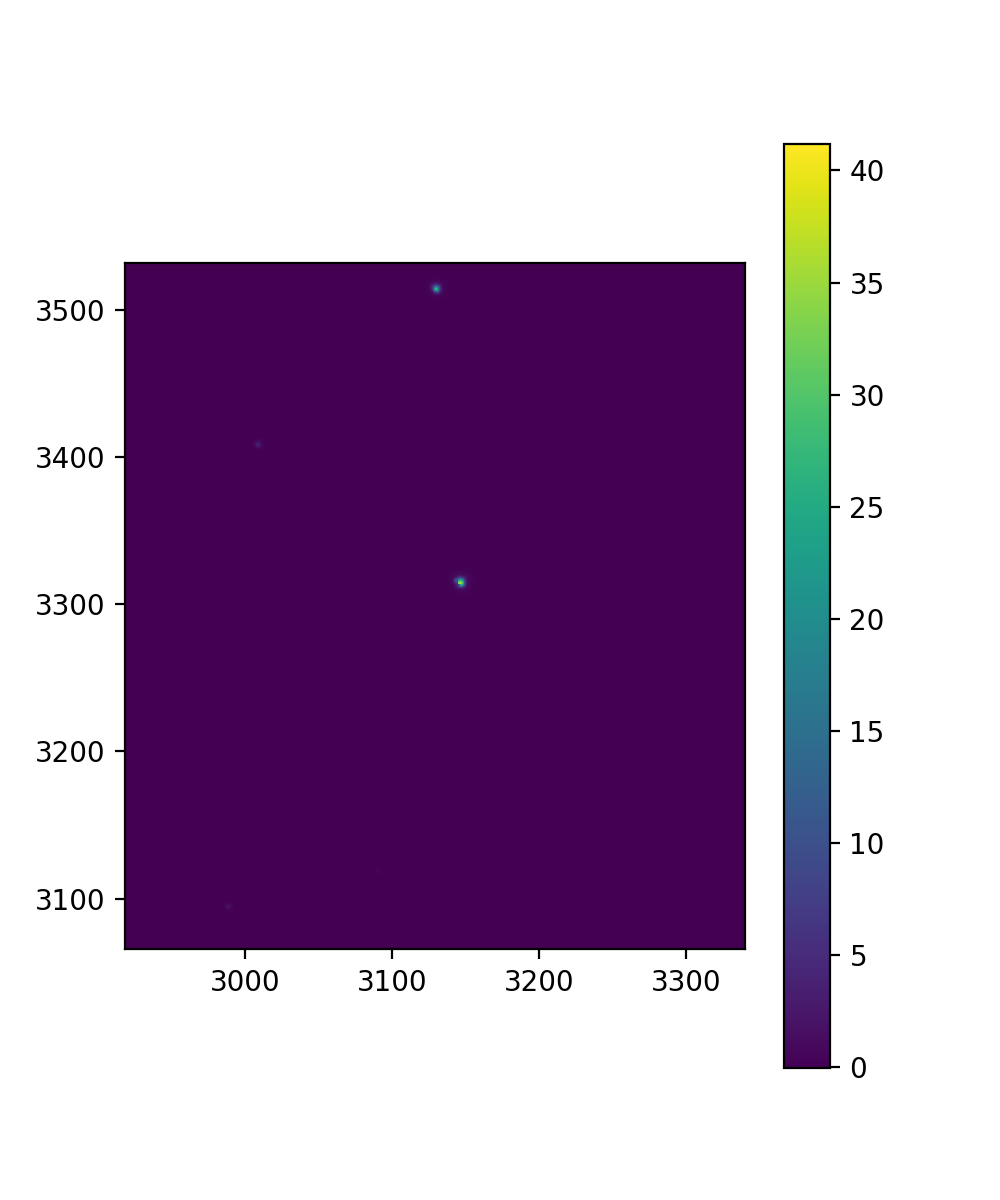

In [28]:
%matplotlib notebook
plt.figure(figsize=(5,6))
outimg=imgs[475].copy()
outimg[np.logical_not(regMsks['tail'])]= np.NaN
plt.imshow(outimg)
plt.colorbar()
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


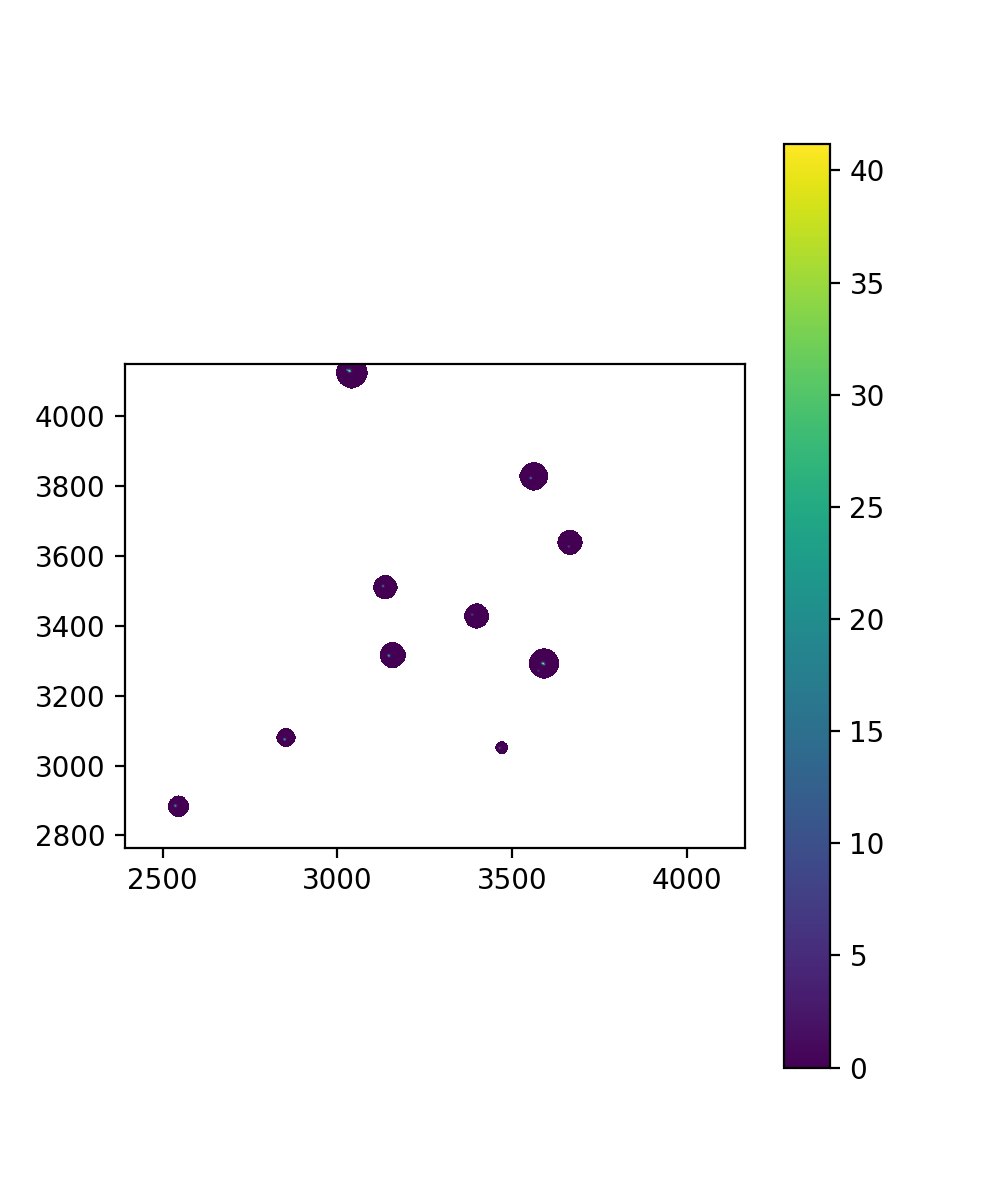

In [32]:
%matplotlib notebook
plt.figure(figsize=(5,6))
outimg=imgs[475].copy()
outimg[np.logical_not(excRegMsks['tail-exc'])]= np.NaN
plt.imshow(outimg)
plt.colorbar()
plt.gca().invert_yaxis()

## use Example Images to verify masked sources

In [53]:
# Uncorrected
with open('F475W-Control-Uncorrected.fits', 'wb') as fid:
    hduList = fits.HDUList()
    outImg = imgs[475].copy()
    outImg[np.logical_not(incRegMsks['control'])] = np.NaN
    outImg[outImg == 0] = np.NaN
    hduList.append(fits.PrimaryHDU())
    hduList.append(fits.ImageHDU(data=outImg, header=hdrs[475]))
    hduList.writeto(fid, overwrite=True)

In [49]:
# Corrected
with open('F475W-Control-Corrected.fits', 'wb') as fid:
    hduList = fits.HDUList()
    outImg = imgs[475].copy()
    outImg[np.logical_not(regMsks['control'])] = np.NaN
    outImg[outImg == 0] = np.NaN
    hduList.append(fits.PrimaryHDU())
    hduList.append(fits.ImageHDU(data=outImg, header=hdrs[475]))
    hduList.writeto(fid, overwrite=True)